# Toxic comment classification with CNN

In [38]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score

In [3]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [4]:
# load in pre-trained word vectors
word2vec = {}
with open("./large_files/glove.6B/glove.6B.{}d.txt".format(EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.array(values[1:], dtype='float32')
        word2vec[word] = vec

In [68]:
# prepare text samples and their labels
train = pd.read_csv("./large_files/toxic/train.csv")
test = pd.read_csv("./large_files/toxic/test.csv")

In [72]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [73]:
sentences = train['comment_text'].fillna("dummy_value").values
sentences_test = test['comment_text'].fillna("dummy_value").values
possible_labels = ["toxic", "severe_toxic",
                   "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

In [8]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [9]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])
print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [10]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [28]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of target tensor:', targets.shape)

Shape of data tensor: (159571, 100)
Shape of target tensor: (159571, 6)


In [12]:
# prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, idx in word2idx.items():
    if idx < MAX_VOCAB_SIZE:
        embedding_vec = word2vec.get(word)
        if embedding_vec is not None:
            embedding_matrix[idx] = embedding_vec

In [22]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [23]:
# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

In [34]:
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

In [35]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)           

In [36]:
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT)

Epoch 1/10
998/998 [==============================] - 18s 18ms/step - loss: 0.0844 - accuracy: 0.9803 - val_loss: 0.0818 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 15s 15ms/step - loss: 0.0675 - accuracy: 0.9898 - val_loss: 0.0736 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 14s 14ms/step - loss: 0.0631 - accuracy: 0.9918 - val_loss: 0.0705 - val_accuracy: 0.9940
Epoch 4/10
998/998 [==============================] - 14s 14ms/step - loss: 0.0599 - accuracy: 0.9937 - val_loss: 0.0781 - val_accuracy: 0.9938
Epoch 5/10
998/998 [==============================] - 14s 14ms/step - loss: 0.0576 - accuracy: 0.9937 - val_loss: 0.0699 - val_accuracy: 0.9921
Epoch 6/10
998/998 [==============================] - 14s 14ms/step - loss: 0.0562 - accuracy: 0.9936 - val_loss: 0.0843 - val_accuracy: 0.9933
Epoch 7/10
998/998 [==============================] - 14s 14ms/step - loss: 0.0540 - accuracy: 0.9933 - val_loss: 0.1096 - val_accuracy:

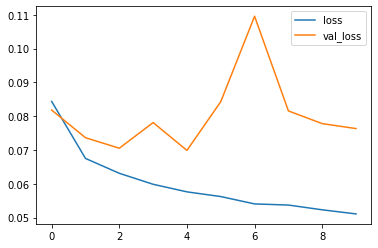

In [40]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

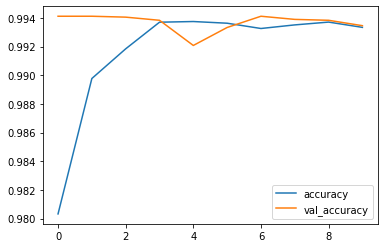

In [41]:
# accuracies
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [43]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(len(possible_labels)):
    auc = roc_auc_score(targets[:, j], p[:, j])
    aucs.append(auc)
print(np.mean(aucs))

0.9771181358648148


In [54]:
p[p > 0.5] = 1
p[p <= 0.5] = 0
result = train[['comment_text']].join(pd.DataFrame(p, columns=possible_labels))

In [66]:
result[result.toxic == 1]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1.0,0.0,1.0,0.0,1.0,0.0
42,You are gay or antisemmitian? \n\nArchangel WH...,1.0,0.0,1.0,0.0,1.0,0.0
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1.0,1.0,1.0,0.0,1.0,0.0
44,I'm Sorry \n\nI'm sorry I screwed around with ...,1.0,0.0,0.0,0.0,0.0,0.0
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
159494,"""\n\n our previous conversation \n\nyou fuckin...",1.0,0.0,1.0,0.0,1.0,0.0
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1.0,0.0,0.0,0.0,0.0,0.0
159541,Your absurd edits \n\nYour absurd edits on gre...,1.0,0.0,1.0,0.0,0.0,0.0
159546,"""\n\nHey listen don't you ever!!!! Delete my e...",1.0,0.0,1.0,0.0,1.0,0.0


# Toxic comment classification with LSTM

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Bidirectional,Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
# load in pre-trained word vectors
word2vec = {}
with open("./large_files/glove.6B/glove.6B.{}d.txt".format(EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.array(values[1:], dtype='float32')
        word2vec[word] = vec

In [4]:
# prepare text samples and their labels
train = pd.read_csv("./large_files/toxic/train.csv")
test = pd.read_csv("./large_files/toxic/test.csv")

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
sentences = train['comment_text'].fillna("dummy_value").values
sentences_test = test['comment_text'].fillna("dummy_value").values
possible_labels = ["toxic", "severe_toxic",
                   "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

In [7]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [8]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])
print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [9]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [10]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of target tensor:', targets.shape)

Shape of data tensor: (159571, 100)
Shape of target tensor: (159571, 6)


In [11]:
# prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, idx in word2idx.items():
    if idx < MAX_VOCAB_SIZE:
        embedding_vec = word2vec.get(word)
        if embedding_vec is not None:
            embedding_matrix[idx] = embedding_vec

In [12]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False
                            )

In [13]:
input_=Input(shape=(MAX_SEQUENCE_LENGTH,))
x=embedding_layer(input_)
x=LSTM(15,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
output=Dense(len(possible_labels),activation='sigmoid')(x)

In [14]:
model=Model(input_,output)
model.compile(loss='binary_crossentropy',
             optimizer=Adam(lr=0.01),
             metrics=['accuracy'])

In [15]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 15)           6960      
_________________________________________________________________
global_max_pooling1d (Global (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 96        
Total params: 2,007,056
Trainable params: 7,056
Non-trainable params: 2,000,000
_________________________________________________________________


In [16]:
r=model.fit(data,targets,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT)

Epoch 1/10
998/998 [==============================] - 17s 17ms/step - loss: 0.0800 - accuracy: 0.9522 - val_loss: 0.0587 - val_accuracy: 0.9940
Epoch 2/10
998/998 [==============================] - 16s 16ms/step - loss: 0.0546 - accuracy: 0.9914 - val_loss: 0.0542 - val_accuracy: 0.9705
Epoch 3/10
998/998 [==============================] - 16s 16ms/step - loss: 0.0513 - accuracy: 0.9856 - val_loss: 0.0531 - val_accuracy: 0.9865
Epoch 4/10
998/998 [==============================] - 16s 16ms/step - loss: 0.0497 - accuracy: 0.9848 - val_loss: 0.0532 - val_accuracy: 0.9894
Epoch 5/10
998/998 [==============================] - 16s 16ms/step - loss: 0.0488 - accuracy: 0.9825 - val_loss: 0.0519 - val_accuracy: 0.9907
Epoch 6/10
998/998 [==============================] - 16s 16ms/step - loss: 0.0479 - accuracy: 0.9804 - val_loss: 0.0526 - val_accuracy: 0.9709
Epoch 7/10
998/998 [==============================] - 16s 16ms/step - loss: 0.0474 - accuracy: 0.9834 - val_loss: 0.0523 - val_accuracy:

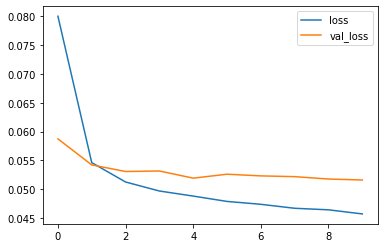

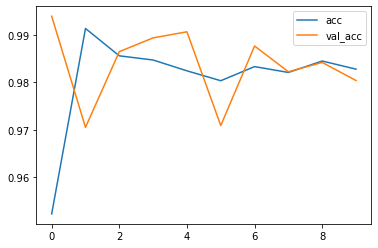

0.9825131648210035


In [17]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))